# Modelo de puntuación de impago
## Librerías necesarias:
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

(CVXPY) Mar 16 07:29:52 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 16 07:29:52 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


# Datos
## Carga de datos
---

In [2]:
dt=pd.read_excel('DatosPractica_Scoring.xlsx')
dt.head()

,ID,Cardhldr,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
0,1,1.0,0.0,27.08333,2.400,0.016798,33.01333,0,0,0,2.400000,56,1,1
1,2,1.0,1.0,24.25000,3.500,0.069963,203.89170,0,0,0,3.500000,60,1,11
2,3,0.0,NaN,27.41667,1.600,0.000750,0.00000,1,0,1,0.800000,30,0,0
3,4,1.0,0.0,40.33333,3.067,0.159700,408.08250,0,0,2,1.022333,18,0,0
4,5,1.0,0.0,28.16667,3.350,0.071625,199.36920,1,0,0,3.350000,18,1,2


## Variables
---
ID: identificador de cada solicitante de tarjeta

Age = Edad n años más doceavos de año

Income = Ingreso anual (dividido por 10,000)

Exp_Inc = Relación entre el gasto mensual de la tarjeta de crédito y el ingreso anual

Avgexp = Gasto promedio mensual con tarjeta de crédito

Ownrent = 1 si es dueño de su casa, 0 si alquila

Selfempl = 1 si es autónomo, 0 si no.

Depndt = número de dependientes (personas a cargo)

Inc_per = Ingreso dividido por (1+número de dependientes)

Cur_add = meses viviendo en la dirección actual

Major = número de las principales tarjetas de crédito retenidas

Active = número de cuentas de crédito activas

In [3]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1319 non-null   int64  
 1   Cardhldr  1285 non-null   float64
 2   default   994 non-null    float64
 3   Age       1319 non-null   float64
 4   Income    1319 non-null   float64
 5   Exp_Inc   1319 non-null   float64
 6   Avgexp    1319 non-null   float64
 7   Ownrent   1319 non-null   int64  
 8   Selfempl  1319 non-null   int64  
 9   Depndt    1319 non-null   int64  
 10  Inc_per   1319 non-null   float64
 11  Cur_add   1319 non-null   int64  
 12  Major     1319 non-null   int64  
 13  Active    1319 non-null   int64  
dtypes: float64(7), int64(7)
memory usage: 144.4 KB


In [4]:
dt.nunique()

ID          1319
Cardhldr       2
default        2
Age          418
Income       431
Exp_Inc     1162
Avgexp       981
Ownrent        2
Selfempl       2
Depndt         7
Inc_per      529
Cur_add      193
Major          2
Active        35
dtype: int64

# Tipo de variable
---

Hay 5 variables categóricas y 9 numéricas

variables_categoricas = ['default', 'Major', 'Ownrent','Selfempl','Cardhldr']
for i in variables_categoricas:
    dt[i] = dt[i].astype('category')
dt.info()

# ID
---

In [5]:
dt.set_index('ID',inplace=True)

## Descripción de los datos
---
**Default**: Variable objetivo, indica si un cliente ha hecho impago durante la ventana de observación.
Default = 1 if defaulted 0 if not (observed only when Cardhldr = 1)

**Cardhldr=1**: Clientes aceptados, son clientes a los que se le ha dado la tarjeta de crédito (Cardhldr=1) y sobre los que sabemos si han impagado alguna vez o no (default= 1 o 0 respectivamente).

**Cardhldr=0**: clientes rechazados, son clientes que solicitaron un crédito pero a los que se negó su solicitud (Cardhldr=0), son clientes a los que no se les concedió la tarjeta, y por tanto no sabemos si hubieran impagado o no (default= na) porque no se les concedió la tarjeta de crédito.

**(Cardhldr=na)**: solicitud de nuevos clientes que solicitan una tarjeta de créditos y que hay que puntuar. Estos clientes están al final del archivo, son los 34 nuevos potenciales clientes (Cardhldr=na) con identificador de cliente desde 1286 hasta 1319, que están solicitando una tarjeta de crédito. Vosotros tendréis que puntuar su calidad crediticia y concederles o no el préstamo.

Divido el dataset en 3: 
    
   - Clientes aceptados
   - Clientes rechazados
   - Nuevos clientes

In [6]:
Aceptados = pd.DataFrame(dt.loc[dt['Cardhldr']==1])
Aceptados.drop(['Cardhldr'],axis=1,inplace=True)

Rechazados = pd.DataFrame(dt.loc[dt['Cardhldr']==0])
Rechazados.drop(['Cardhldr'],axis=1,inplace=True)

Nuevos = pd.DataFrame(dt.loc[dt['Cardhldr'].isna()])
Nuevos.drop(['Cardhldr'],axis=1,inplace=True)

# Enunciado 1
---
---

Suponga que toma todos los clientes Aceptados y hace un primer análisis exploratorio sin depurar, ni transformar ninguna de las variables explicativas, y utilizando todas las observaciones del fichero (los 994 clientes aceptados, esto es sin dividir la muestra para entrenamiento y test).

Por favor indique a continuación cual es el Valor de la información de cada una de esas variables potencialmente predictoras

## Variable objetivo y variables explicativas
---


In [7]:
# 1) Definimos la lista de nombres señalando cuales de ellas son las categóricas
Y = Aceptados['default'].values
X = Aceptados.drop(['default'],axis=1)  #todas menos la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

## Criterio de selección
---

In [8]:
# 2) Definimos el criterio de selección, valor de la información es > 0,2
selection_criteria = {
    "iv": {"min": 0.02, "max": 1}
}

## Tramificación
---

In [9]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria)

In [10]:
# 4) Obtenemos los tramos óptimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

In [11]:
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
6,Depndt,numerical,OPTIMAL,False,4,0.005121,0.00064,0.035048,0.000135
5,Selfempl,numerical,OPTIMAL,False,2,0.011895,0.001478,0.028111,0.005643
4,Ownrent,numerical,OPTIMAL,False,2,0.011976,0.001496,0.054689,0.02354
9,Major,numerical,OPTIMAL,True,2,0.030557,0.003792,0.059399,0.039958
7,Inc_per,numerical,OPTIMAL,True,7,0.15624,0.018334,0.183395,0.025607
2,Exp_Inc,numerical,OPTIMAL,True,5,0.187134,0.02197,0.191595,0.194671
8,Cur_add,numerical,OPTIMAL,True,6,0.192857,0.023537,0.232347,0.002619
1,Income,numerical,OPTIMAL,True,5,0.222999,0.026768,0.215741,0.055953
0,Age,numerical,OPTIMAL,True,7,0.224977,0.026616,0.236603,0.021707
3,Avgexp,numerical,OPTIMAL,True,7,0.271663,0.031598,0.243863,0.018436


---
---
# Enunciado 2
Con toda esta información, y considerando tanto a los clientes Aceptados, como a los Rechazados (haciendo inferencia de rechazados), realice un pronóstico para las solicitudes de los nuevos clientes (los clientes con un ID desde el 1286 hasta 1319). Se recomienda realizar un análisis exploratorio previo para depurar los datos que se van a utilizar en la estimación de los modelos (depuración de datos atípicos, variables con poca variabilidad, transformación de variables), y dividir la muestra para entrenamiento y test para validar sus modelos).

Por favor indique a continuación a cuales de las siguientes 25 nuevas solicitudes SÍ concede el crédito (marque todas las solicitudes a las que concedería el crédito)

## Reporte descriptivo
---

Cont


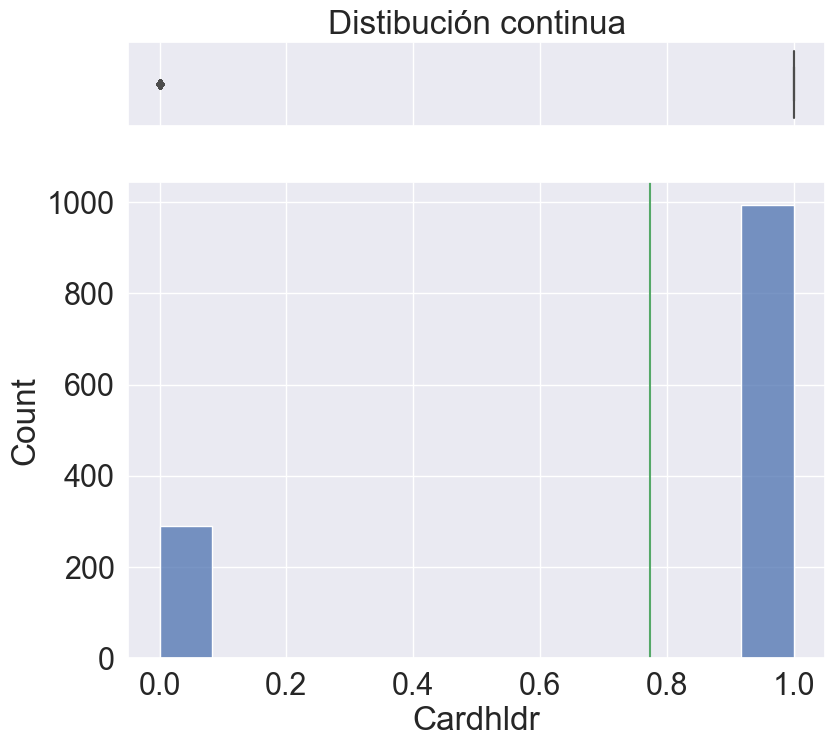

Cont


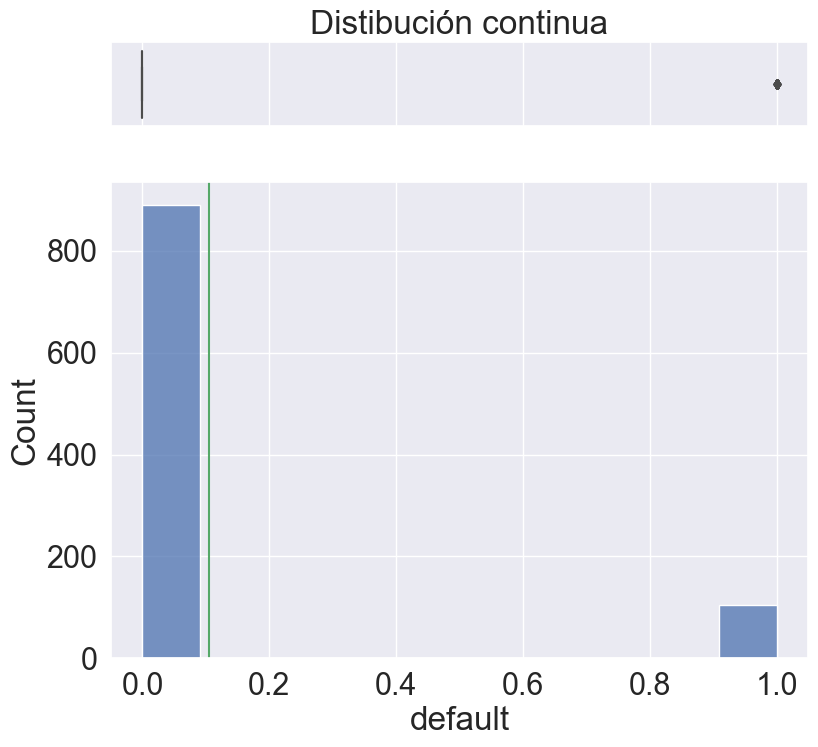

Cont


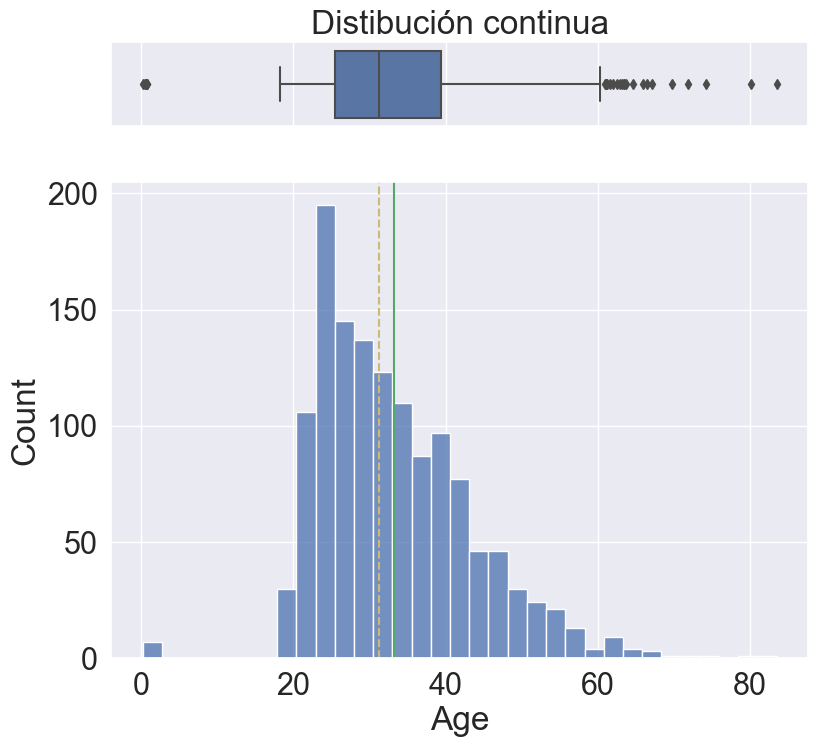

Cont


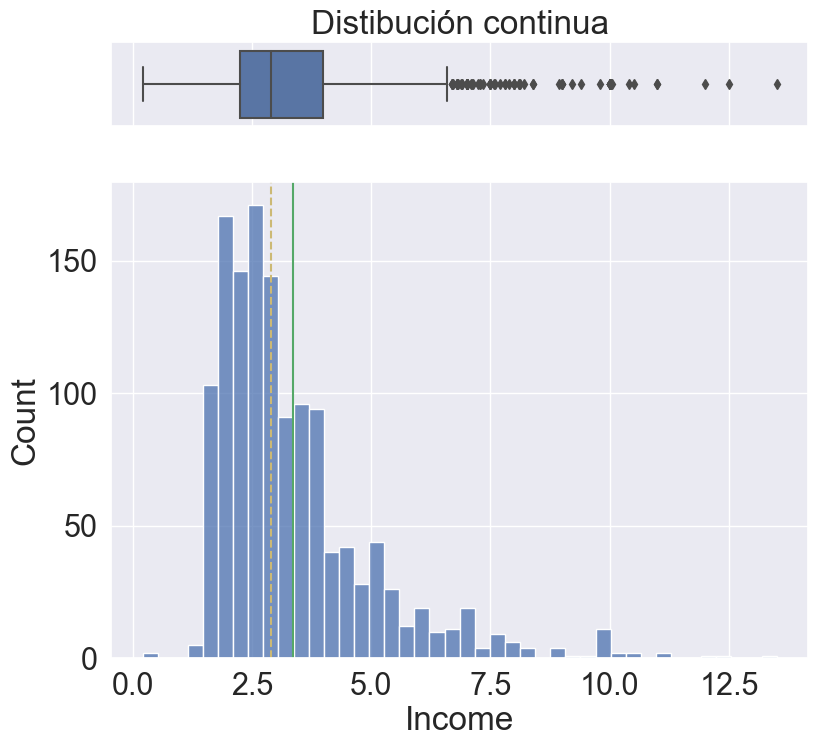

Cont


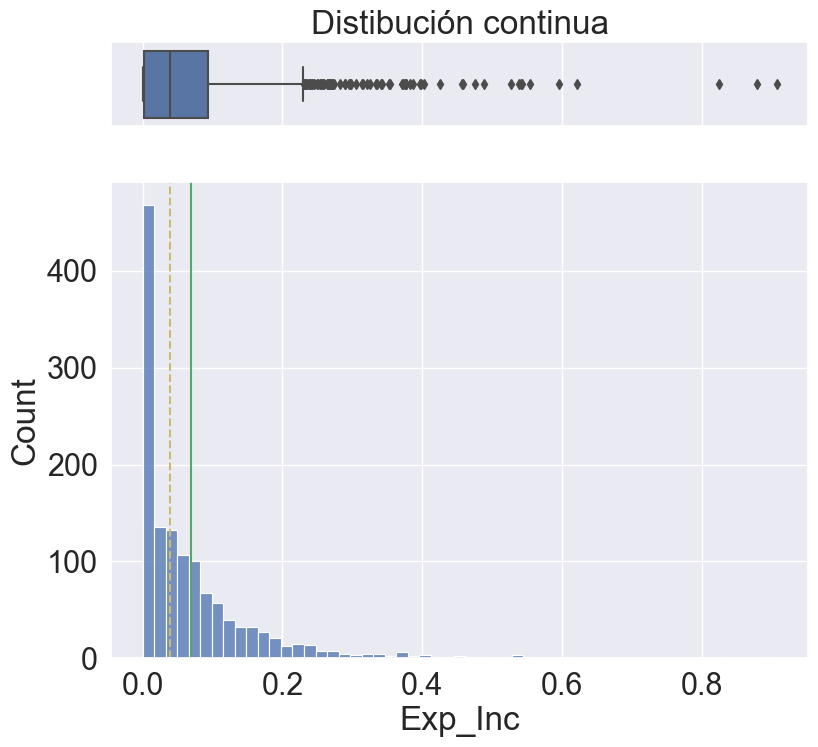

Cont


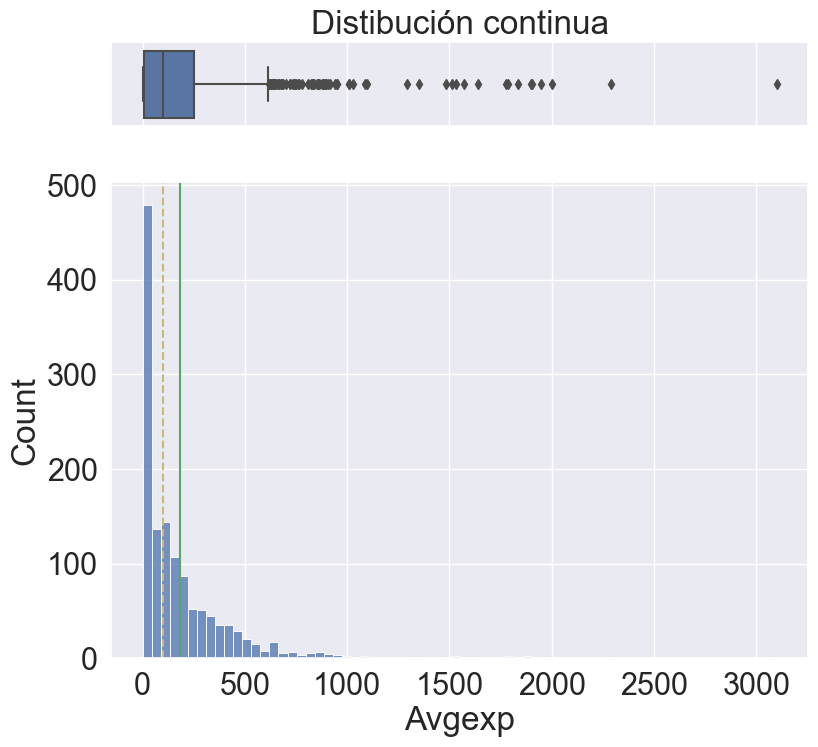

Cont


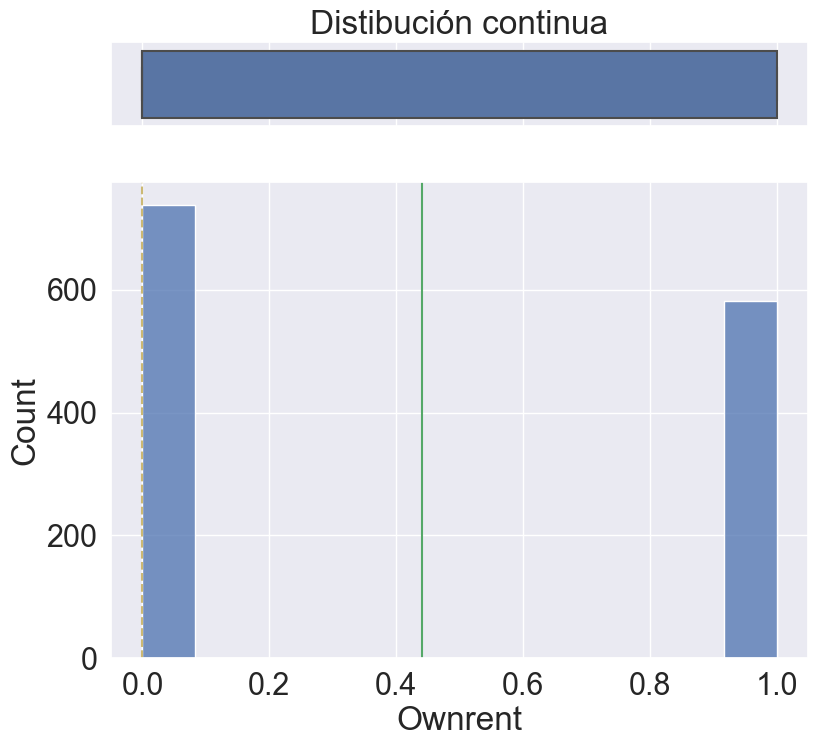

Cont


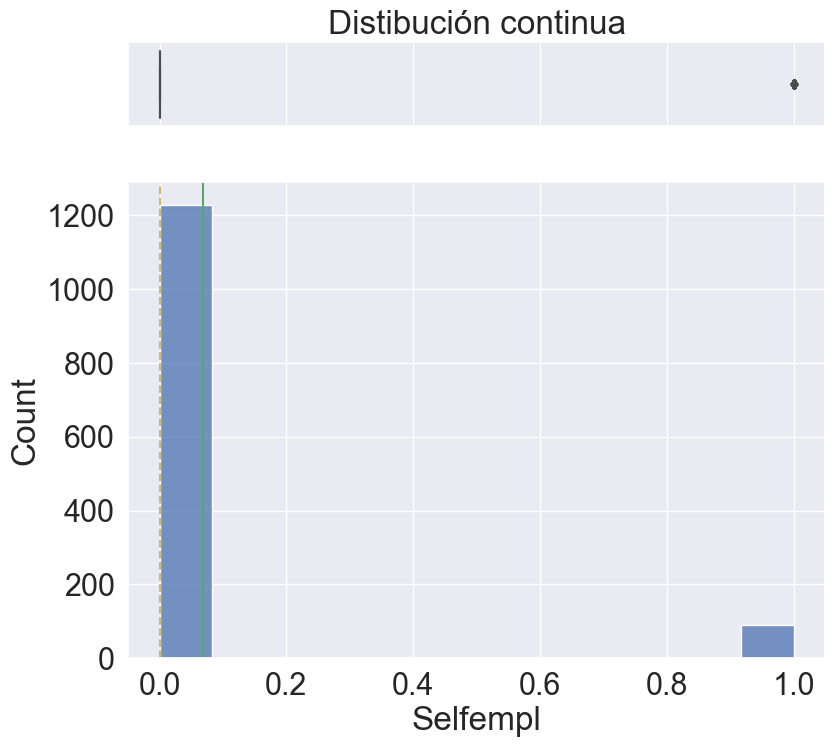

Cont


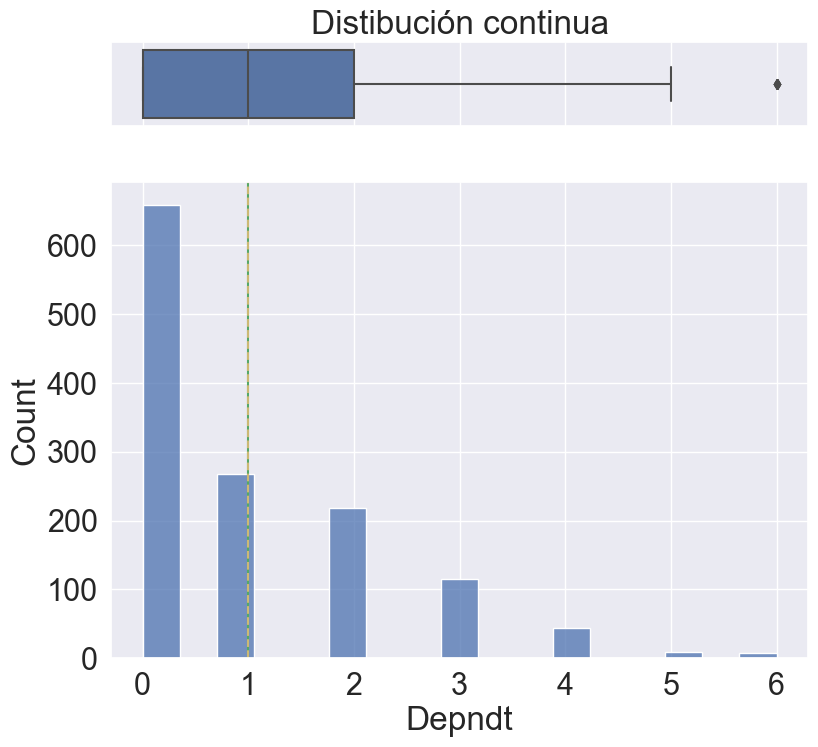

Cont


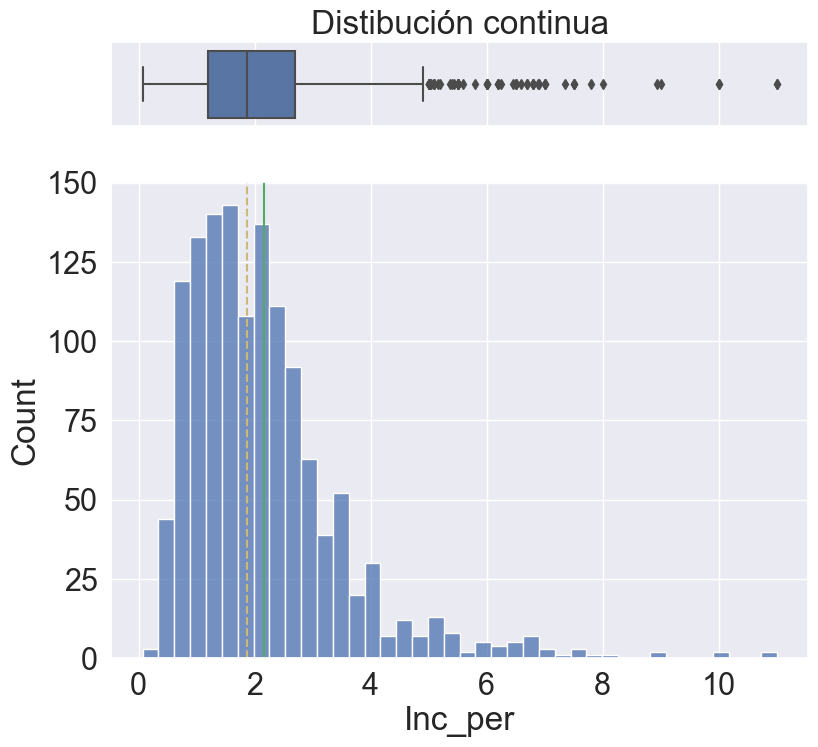

Cont


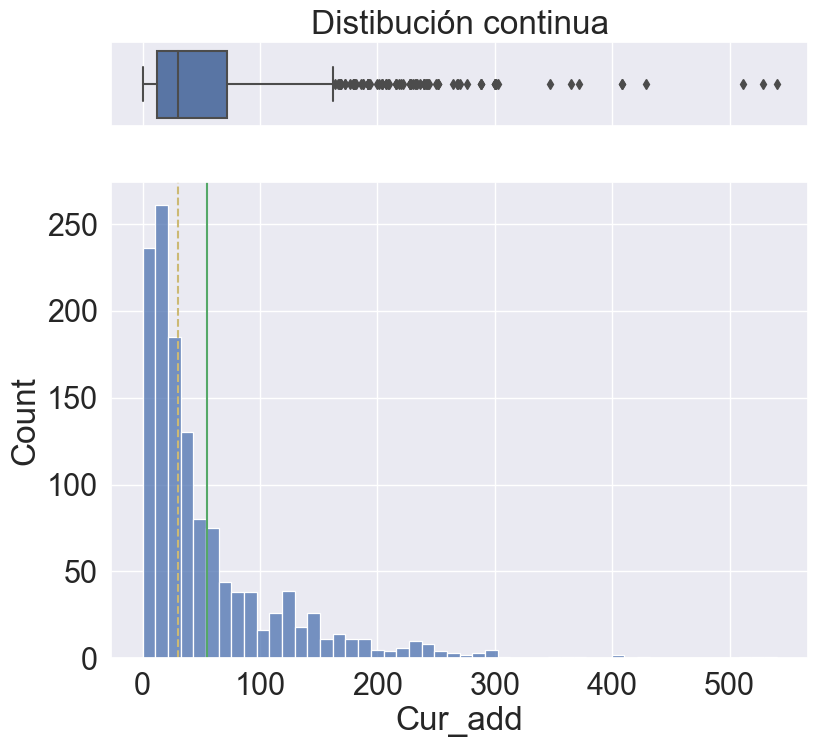

Cont


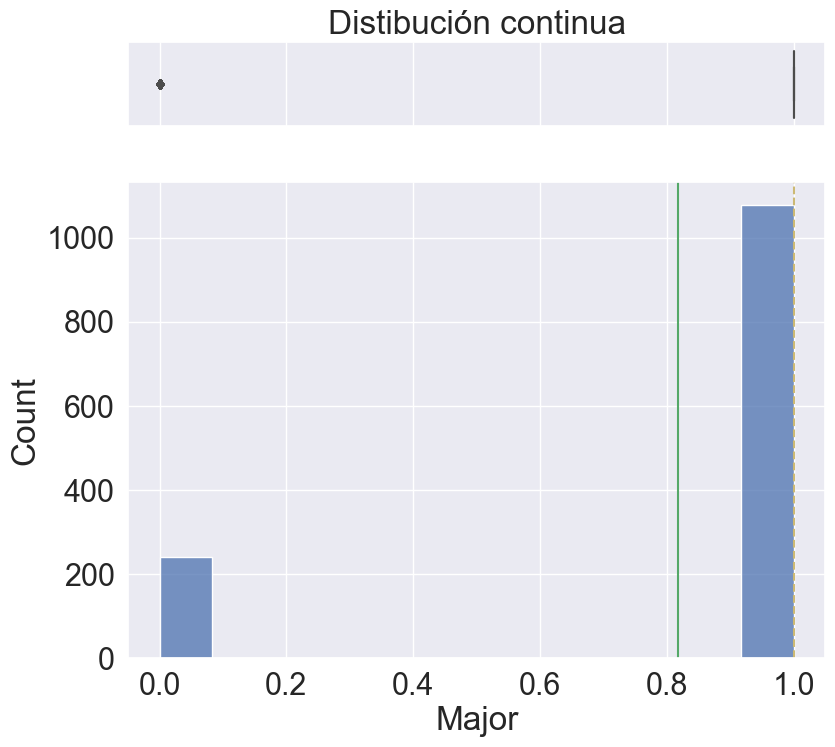

Cont


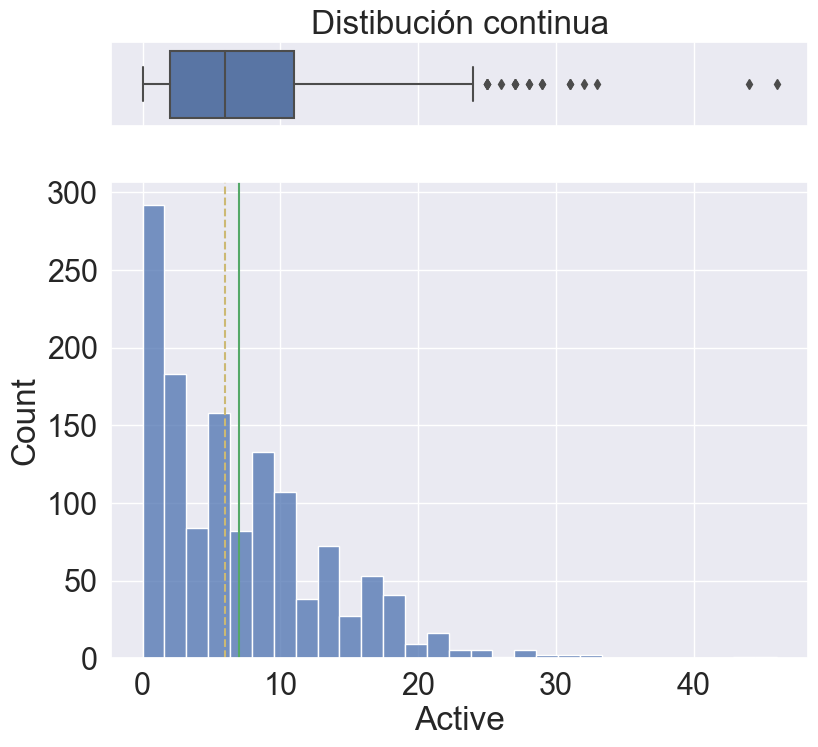

Cardhldr    None
default     None
Age         None
Income      None
Exp_Inc     None
Avgexp      None
Ownrent     None
Selfempl    None
Depndt      None
Inc_per     None
Cur_add     None
Major       None
Active      None
dtype: object

In [12]:
import plotly.express as px
def histogram_boxplot(data, xlabel = None, title = None, font_scale=2, figsize=(9,8), bins = None):
    # Definir tamaño letra
    sns.set(font_scale=font_scale)
    # Crear ventana para los subgráficos
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    # Crear boxplot
    sns.boxplot(x=data, ax=ax_box2)
    # Crear histograma
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    # Pintar una línea con la media
    ax_hist2.axvline(np.mean(data),color='g',linestyle='-')
    # Pintar una línea con la mediana
    ax_hist2.axvline(np.median(data),color='y',linestyle='--')
    # Asignar título y nombre de eje si tal
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title, xlabel="")
    # Mostrar gráfico
    plt.show()
    
def cat_plot(col):
     if col.dtypes == 'category':
        fig = px.bar(col.value_counts())
        #fig = sns.countplot(x=col)
        return(fig.show())
    
def plot(col):
     if col.dtypes != 'category':
        print('Cont')
        histogram_boxplot(col, xlabel = col.name, title = 'Distibución continua')
     else:
        print('Cat')
        cat_plot(col)
        


dt.apply(plot)


## Variables
---
ID: identificador de cada solicitante de tarjeta

Age = Edad n años más doceavos de año

Income = Ingreso anual (dividido por 10,000)

Exp_Inc = Relación entre el gasto mensual de la tarjeta de crédito y el ingreso anual

Avgexp = Gasto promedio mensual con tarjeta de crédito

Ownrent = 1 si es dueño de su casa, 0 si alquila

Selfempl = 1 si es autónomo, 0 si no.

Depndt = número de dependientes (personas a cargo)

Inc_per = Ingreso dividido por (1+número de dependientes)

Cur_add = meses viviendo en la dirección actual

Major = número de las principales tarjetas de crédito retenidas

Active = número de cuentas de crédito activas

# Edad
---

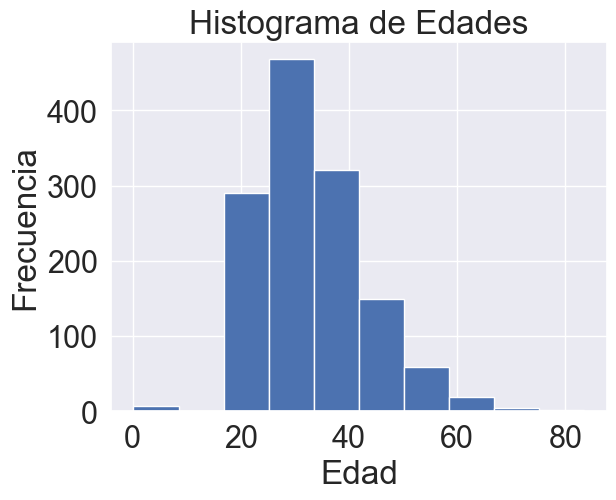

In [13]:
import matplotlib.pyplot as plt

# Crear el histograma
plt.hist(dt['Age'])

# Agregar etiquetas y título
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Histograma de Edades')

# Mostrar el histograma
plt.show()

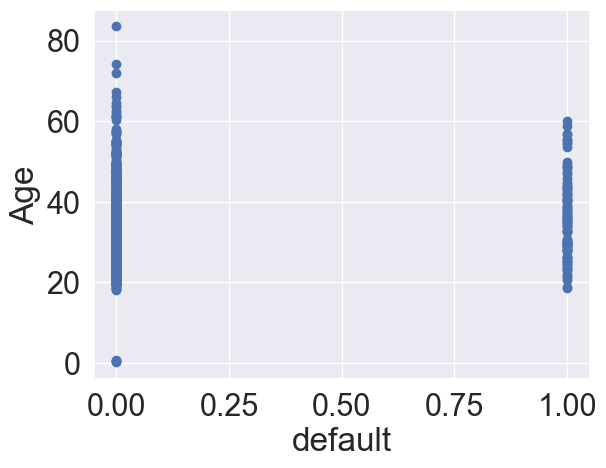

In [14]:
import matplotlib.pyplot as plt

# Crear un diagrama de dispersión con la columna 'Age' en el eje x y la columna 'default' en el eje y
plt.scatter(dt['default'], dt['Age'])

# Establecer las etiquetas de los ejes
plt.xlabel('default')
plt.ylabel('Age')

# Mostrar el gráfico
plt.show()

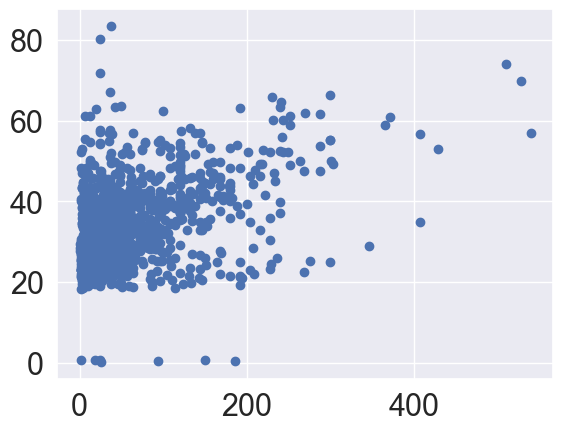

In [15]:
import matplotlib.pyplot as plt

# Crear un diagrama de dispersión con la columna 'Age' en el eje x y la columna 'default' en el eje y
plt.scatter(dt['Cur_add'], dt['Age'])
# Mostrar el gráfico
plt.show()

In [16]:
dt.sort_values('Age', ascending=True).head(10)

,Cardhldr,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
ID,,,,,,,,,,,,,
473,1.0,0.0,0.166667,3.240,0.184366,497.705800,1,0,3,0.810,25,1,16
1307,NaN,NaN,0.500000,3.700,0.010637,32.464160,0,0,0,3.700,186,0,5
1173,1.0,0.0,0.500000,3.050,0.101724,258.549200,0,0,1,1.525,94,1,5
434,1.0,0.0,0.583333,2.500,0.083171,173.023300,0,0,0,2.500,150,1,5
565,1.0,0.0,0.583333,4.000,0.072664,242.128300,1,0,3,1.000,24,1,4
334,0.0,NaN,0.750000,3.000,0.000400,0.000000,0,0,0,3.000,18,0,2
1140,1.0,0.0,0.750000,1.600,0.154191,205.254200,0,0,0,1.600,1,1,9
148,1.0,0.0,18.166670,2.820,0.041854,97.940000,0,0,0,2.820,2,0,1
287,1.0,0.0,18.416670,1.968,0.006455,9.753333,0,0,0,1.968,114,0,2


In [17]:
dt.loc[dt['Age'] < 1, 'Age'] = np.nan

Como la variable está fuertemente correlada con la variable Cur_add

In [18]:
dt['Cur_add'].isna().sum()

0

#### KNNImputer

In [19]:
from sklearn.impute import KNNImputer

# Crear un objeto KNNImputer con n_neighbors=5
imputer = KNNImputer(n_neighbors=5)

# Seleccionar solo la columna 'Age' del dataframe 'dt'
dt_age = dt[['Age','Cur_add']]

# Imputar los valores faltantes en la columna 'Age'
dt_age_imputed = imputer.fit_transform(dt_age)
dt['Age'] = pd.Series(dt_age_imputed[:, 0])

In [20]:
dt.sort_values('Age', ascending=True).head(10)

,Cardhldr,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
ID,,,,,,,,,,,,,
147,1.0,0.0,18.16667,1.56,0.067166,87.14917,0,0,0,1.560000,24,0,5
286,1.0,0.0,18.41667,6.20,0.006145,31.00000,1,0,2,2.066667,132,1,14
1001,1.0,0.0,18.50000,2.50,0.029833,61.73583,1,0,2,0.833333,120,0,4
653,1.0,0.0,18.66667,5.50,0.334460,1532.77300,1,0,4,1.100000,74,1,19
1017,1.0,0.0,18.75000,1.90,0.273122,432.35920,0,0,0,1.900000,19,1,6
603,1.0,0.0,19.00000,5.40,0.071380,321.21080,1,0,3,1.350000,24,1,4
1249,1.0,0.0,19.00000,2.55,0.239594,509.05420,0,0,1,1.275000,90,1,3
1034,1.0,1.0,19.00000,3.20,0.156719,417.83500,0,0,0,3.200000,14,1,6
781,1.0,0.0,19.08333,2.60,0.877846,1902.00000,0,0,0,2.600000,4,1,7


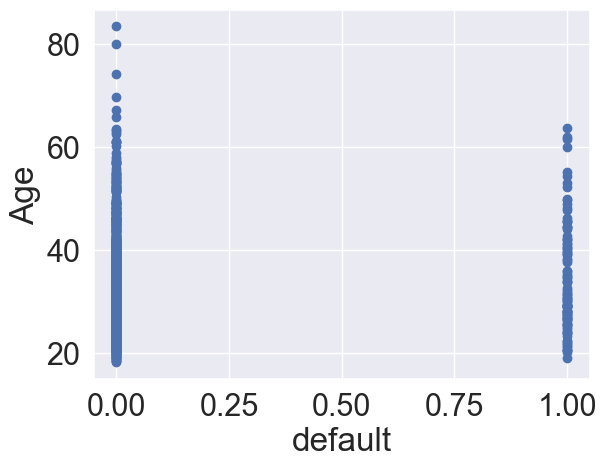

In [21]:
import matplotlib.pyplot as plt

# Crear un diagrama de dispersión con la columna 'Age' en el eje x y la columna 'default' en el eje y
plt.scatter(dt['default'], dt['Age'])

# Establecer las etiquetas de los ejes
plt.xlabel('default')
plt.ylabel('Age')

# Mostrar el gráfico
plt.show()

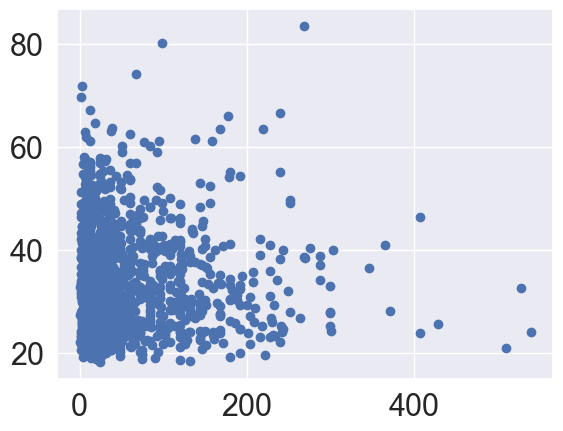

In [22]:
import matplotlib.pyplot as plt

# Crear un diagrama de dispersión con la columna 'Age' en el eje x y la columna 'default' en el eje y
plt.scatter(dt['Cur_add'], dt['Age'])
# Mostrar el gráfico
plt.show()

## Variable objetivo

In [23]:
dt.default.value_counts()

0.0    890
1.0    104
Name: default, dtype: int64

In [24]:
dt.default.value_counts(normalize=True)

0.0    0.895372
1.0    0.104628
Name: default, dtype: float64

Hay un 10,46% de clientes impagados

# Primer Modelo
---
Construcción del primer modelo sólo con los Aceptados

## División de la muestra en entrenamiento y test

In [25]:
dt_train, dt_test = train_test_split(Aceptados,stratify=Aceptados["default"], test_size=.25, random_state=1234)

In [26]:
dt_train["default"].value_counts(normalize=True)

0.0    0.895302
1.0    0.104698
Name: default, dtype: float64

In [27]:
dt_test["default"].value_counts(normalize=True)

0.0    0.895582
1.0    0.104418
Name: default, dtype: float64

La estratificación se ha realizado correctamente

## Defino la tramificación óptima

In [28]:
# 1) Definimos la lista de nombres señalando cuales de ellas son las categóricas
Y = dt_train['default'].values
X = dt_train.drop(columns=['default']) #todas menos la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

In [29]:
# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02, "max": 1}
}

In [30]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria)

In [31]:
# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

In [32]:
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
4,Ownrent,numerical,OPTIMAL,False,2,0.004974,0.000622,0.035232,0.00612
9,Major,numerical,OPTIMAL,False,2,0.016134,0.002009,0.043536,0.016039
5,Selfempl,numerical,OPTIMAL,False,2,0.019567,0.002422,0.035771,0.009448
6,Depndt,numerical,OPTIMAL,True,3,0.023471,0.002916,0.054627,0.017307
7,Inc_per,numerical,OPTIMAL,True,6,0.117044,0.014205,0.165417,0.026038
8,Cur_add,numerical,OPTIMAL,True,5,0.165855,0.020396,0.211702,0.029017
0,Age,numerical,OPTIMAL,True,6,0.205791,0.024826,0.227771,0.033651
2,Exp_Inc,numerical,OPTIMAL,True,4,0.212908,0.024448,0.18114,0.461491
1,Income,numerical,OPTIMAL,True,5,0.235324,0.02751,0.180448,0.114868
3,Avgexp,numerical,OPTIMAL,True,6,0.246,0.028613,0.227175,0.141


# Estimación del Modelo

Ahora podemos calcular la tarjeta de puntuación. En los apuntes de clase definimos tanto los WOE, como los Odd ratio como la probabilidad de `evento` respecto al `no-evento` (malos clientes o impago=1 respecto a los buenos clientes o impago=0):

$$ odd = {{P}\over {(1-P)}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$
 
 Y la fórmula para obtener la puntuación o los score debe ser una relación negativa con los odd ratio: cuanto mayor la probabilidad de impago (en relación a la de no impago), menor puntuación ha de tener: 

 $$ score {= offset - Factor}~·~{ln(odds)}$$

 para obtener los valores concretos de esta recta que transforma probabilidades a puntos (para conocer el valor de $offset$ y de $Factor$), hay que decidir de manera arbitraria una pendiente y un punto de la anterior recta. Para la pendiente suele establecerse cada cuántos puntos de score (**pdo_0**) que dobla el odd ratio: $ score - pdo_0 = {offset -Factor}~ ·{ln(2*odds)}$. Mientras que para establecer un punto de la recta se establece una puntuación o score arbitraria que se considere que debería tener un cliente con una calidad credicitica de *sobresaliente* (**scorecard_points**), y también el odd ratio que debería tener ese cliente de *sobresaliente* (**odds_0**). Así habría que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600 
* **odds_0** =1/50

La librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/), en realidad utiliza el módulo de `credit scoring` de `SAS-miner` como inspiración, y por eso define al revés tanto los WOE como los odd ratio, es decir `no-evento` en relación a `evento` (clientes buenos respecto a los malos, o no-impago respecto a impago, impago=0 respecto a impago=1). 
$$ odd^B = {{(1-P)}\over {P}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$

Esto implica que la ecuación que transforma las probabilidades de impago en scores utilizando esta *odds<sup>B</sup>* debe tener pendiente positiva (cuanto mejor *odd<sup>B</sup>* mejor calidad crediticia tiene el cliente)

 $$ score= {offset + Factor} ~·~ {ln(odds^B)}$$
 
 Nótese que ahora habrá que establecer de nuevo los puntos de score que doblan el odd ratio (**pdo_0**), y también la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* **odds_0 <sup>*B*</sup>**, con **odds_0 <sup>*B*</sup>** **= 1/odds_0**.

 Así para estimar la puntuación crediticia con `optBinning` hay que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600 
* **odds_0 <sup>*B*</sup>** = 50  (equivalente a **odds_0** =1/50 )




In [33]:
# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(categorical_variables=[],
                                         selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.02}},
                                         variable_names=['Age', 'Income',
                                                         'Exp_Inc', 'Avgexp',
                                                         'Ownrent', 'Selfempl',
                                                         'Depndt', 'Inc_per',
                                                         'Cur_add', 'Major',
                                                         'Active']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [34]:
tarjeta.information(print_level=2)

optbinning (Version 0.17.3)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                  pdo_odds   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                    745
    Number of variables                   11
    Target type                       binary

    Number of numerical                   11
    Number of categorical                  0
    Number of selected                     8

  Timing
    Total time                          1.17 sec
    Binning process                     1.14 sec   ( 97.42%)
    Estimator                           0.00 sec   (  0.37%

In [35]:
tarjeta.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,Age,0,"(-inf, 24.1250)",121,0.162416,113,8,0.066116,0.501865,0.033550,4.150320e-03,-0.585301,78.895805
1,Age,1,"[24.1250, 29.1250)",196,0.263087,182,14,0.071429,0.418868,0.039112,4.853619e-03,-0.585301,76.092464
2,Age,2,"[29.1250, 35.7083)",167,0.224161,148,19,0.113772,-0.093308,0.002025,2.530140e-04,-0.585301,58.792975
3,Age,3,"[35.7083, 38.2917)",44,0.059060,32,12,0.272727,-1.165252,0.123365,1.460348e-02,-0.585301,22.586510
4,Age,4,"[38.2917, 44.9583)",119,0.159732,104,15,0.126050,-0.209741,0.007632,9.521985e-04,-0.585301,54.860295
5,Age,5,"[44.9583, inf)",98,0.131544,88,10,0.102041,0.028671,0.000107,1.336324e-05,-0.585301,62.912973
6,Age,6,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000e+00,-0.585301,61.944585
7,Age,7,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000e+00,-0.585301,61.944585
0,Income,0,"(-inf, 4.0050)",560,0.751678,504,56,0.100000,0.051143,0.001927,2.408172e-04,-0.620704,63.776513
1,Income,1,"[4.0050, 4.5400)",42,0.056376,41,1,0.023810,1.567491,0.076256,8.662275e-03,-0.620704,118.091274


In [36]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)


0.1047

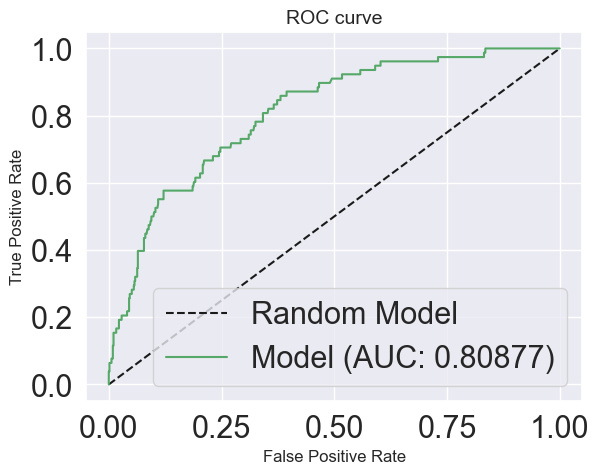

In [37]:
# Diagnosis Curva ROC
plot_auc_roc(Y,Y_pred)

In [38]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test = dt_test['default'].values
X_test = dt_test.drop(columns=['default']) #todas menos la primera que es el ID y la variable y

Y_test_pred=tarjeta.predict_proba(X_test)[:,1]


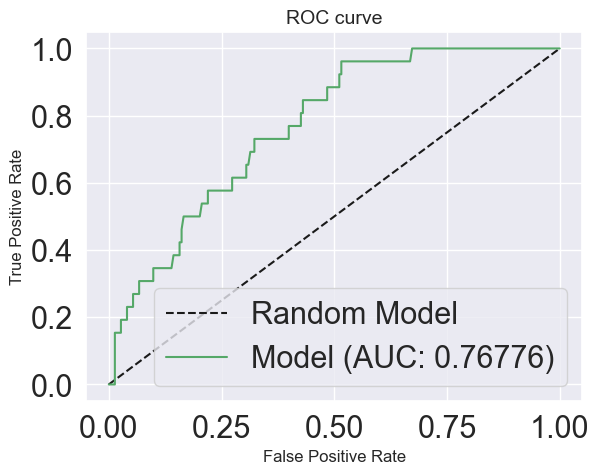

In [39]:
# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)


# Realizamos la inferencia de Rechazados

In [40]:
from sklearn.metrics import f1_score
# primero estimo el punto de corte utilizando el valor medio (calculo su f1-score)
Prob_Corte=Y.mean()
f1_score(Y,Y_pred>Y_pred.mean())

0.33608815426997246

In [45]:
Rechazados.fillna({'default': 1})

,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
ID,,,,,,,,,,,,
3,1.0,27.41667,1.600,0.000750,0.0,1,0,1,0.800,30,0,0
6,1.0,34.25000,1.944,0.000617,0.0,0,0,1,0.972,54,1,1
9,1.0,22.66667,1.500,0.000800,0.0,0,0,3,0.375,14,1,4
13,1.0,34.75000,2.670,0.000449,0.0,0,0,0,2.670,51,1,25
16,1.0,41.83333,3.500,0.000343,0.0,0,0,0,3.500,54,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1272,1.0,23.83333,2.550,0.000471,0.0,1,0,2,0.850,24,1,0
1274,1.0,56.00000,1.450,0.000828,0.0,1,0,0,1.450,242,1,4
1277,1.0,29.50000,3.000,0.000400,0.0,1,0,2,1.000,60,1,8


In [46]:
# Hacemos la inferencia
X_rechazados = Rechazados.drop(columns=['default']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_rechazados_pred=tarjeta.predict_proba(X_rechazados)[:,1]
Rechazados["default"]=np.multiply(Y_rechazados_pred>Prob_Corte,1)


In [47]:
# Hago también una primera estimazión de la puntuación de los nuevos clientes para ver si hay diferencias con y sin rechazados
X_Nuevos = Nuevos.drop(columns=['default']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
Nuevos["y_Sinrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)


# Anexamos los datos de los Rechazados inferidos a los Aceptados

In [57]:
dt=pd.concat([Aceptados,Rechazados], axis=0)

In [58]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 1 to 1282
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   default   1285 non-null   float64
 1   Age       1285 non-null   float64
 2   Income    1285 non-null   float64
 3   Exp_Inc   1285 non-null   float64
 4   Avgexp    1285 non-null   float64
 5   Ownrent   1285 non-null   int64  
 6   Selfempl  1285 non-null   int64  
 7   Depndt    1285 non-null   int64  
 8   Inc_per   1285 non-null   float64
 9   Cur_add   1285 non-null   int64  
 10  Major     1285 non-null   int64  
 11  Active    1285 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 130.5 KB


In [59]:
dt['default'].value_counts(normalize=True)

0.0    0.8607
1.0    0.1393
Name: default, dtype: float64

In [60]:
dt['default'].value_counts(normalize=True)

0.0    0.8607
1.0    0.1393
Name: default, dtype: float64

# Reestimo el modelo con todos, Aceptados y rechazados

In [61]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 1 to 1282
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   default   1285 non-null   float64
 1   Age       1285 non-null   float64
 2   Income    1285 non-null   float64
 3   Exp_Inc   1285 non-null   float64
 4   Avgexp    1285 non-null   float64
 5   Ownrent   1285 non-null   int64  
 6   Selfempl  1285 non-null   int64  
 7   Depndt    1285 non-null   int64  
 8   Inc_per   1285 non-null   float64
 9   Cur_add   1285 non-null   int64  
 10  Major     1285 non-null   int64  
 11  Active    1285 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 130.5 KB


In [62]:
### Dividimos la muestra en entrenamiento y test
dt_train, dt_test = train_test_split(dt,stratify=dt["default"], test_size=.25, random_state=1234)
dt_train["default"].mean()
dt_test["default"].mean()
### Defino la tramificación óptima

# 1) Definimos la lista de nombres señalando cuales de ellas son las categóricas
Y = dt_train['default'].values
X = dt_train.drop(columns=['default']) #todas menos la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02, "max": 1}
}
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
5,Selfempl,numerical,OPTIMAL,False,2,0.006392,0.000795,0.01795,0.00234
9,Major,numerical,OPTIMAL,False,2,0.015658,0.001951,0.044425,0.019198
4,Ownrent,numerical,OPTIMAL,True,2,0.026053,0.003253,0.080442,0.065297
6,Depndt,numerical,OPTIMAL,True,3,0.053469,0.006595,0.083665,0.066711
7,Inc_per,numerical,OPTIMAL,True,8,0.149036,0.017982,0.196956,0.002472
1,Income,numerical,OPTIMAL,True,4,0.202946,0.024,0.17806,0.284928
0,Age,numerical,OPTIMAL,True,7,0.333892,0.040006,0.292692,0.040593
3,Avgexp,numerical,OPTIMAL,True,8,0.394881,0.046589,0.324865,0.022875
8,Cur_add,numerical,OPTIMAL,True,7,0.473874,0.055799,0.327413,0.004723
2,Exp_Inc,numerical,OPTIMAL,True,7,0.476448,0.055699,0.353231,0.067305


In [63]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)

0.09662

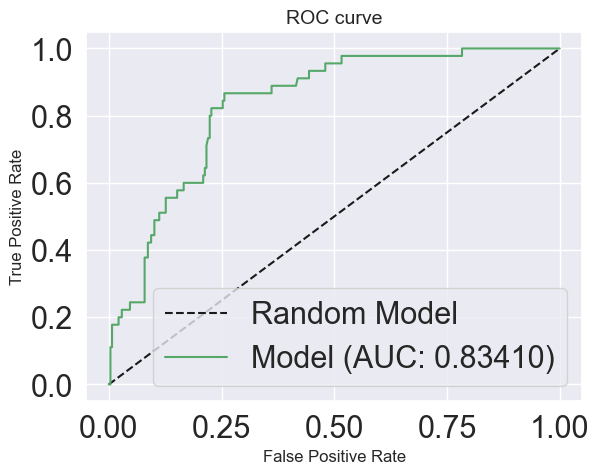

In [65]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test = dt_test['default'].values
X_test = dt_test.drop(columns=['default']) #todas menos la primera que es el ID y la variable y

Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)


# Puntuación de los nuevos cliente

In [67]:
# primero estimo el punto de corte utilizando el valor medio (calculo su f1-score)
Prob_Corte=Y.mean()
print(Prob_Corte)
f1_score(Y,Y_pred>Y_pred.mean())
# Hacemos la inferencia

X_Nuevos = Nuevos.drop(columns=['default']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
Nuevos["y_Conrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)


0.1391484942886812


In [85]:
Nuevos.loc[Nuevos['y_Conrechazados'] == 1, [ 'y_Conrechazados']]

,y_Conrechazados
ID,
1287,1
1290,1
1293,1
1296,1
1297,1
1299,1
1301,1
1304,1
1311,1


In [83]:
filtro = Nuevos.loc[Nuevos['y_Conrechazados']==1]
print(filtro[['ID','y_Conrechazados']])

KeyError: "['ID'] not in index"